In [2]:
import tensorflow as tf
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import itertools
import os
import cv2
import time
from zipfile import ZipFile
from PIL import Image
import io

Link: dataset: https://drive.google.com/drive/folders/1e6D-5uMvumHGWkLI4YOD6VDkDEa4xoJi?usp=sharing

Giải nén thư mục

In [ ]:
zip_file = '/content/sample_data/animal.zip'
with ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall()

Lấy đường dẫn của từng data (ảnh) và gán nhãn cho chúng.

In [ ]:
dataset_path = '/content/animal'
class_label = []
_dict = {'cat': 0,
         'dog': 1,
         'wild': 2}
for train_test in os.listdir(dataset_path):
    if train_test == 'train':
        t = 1
    else:
        t = 0
    all_classes = os.listdir(dataset_path+ '/' + train_test)
    for _class in all_classes:
        all_img = os.listdir(dataset_path+ '/' + train_test + '/' + _class)
        for img in all_img[:200]:
            class_label.append((t, _dict[_class], dataset_path+ '/' + train_test + '/' + _class + '/' + img ))

Đưa về dạng dataframe cho dễ quản lý

In [ ]:
df = pd.DataFrame(data=class_label, columns=['Train', 'Label', 'image'])
df.to_csv('groundtruth.csv', index=False)
print(df)

     Train  Label                                              image
0        1      2  /content/animal/train/wild/flickr_wild_002471.jpg
1        1      2  /content/animal/train/wild/flickr_wild_002588.jpg
2        1      2  /content/animal/train/wild/flickr_wild_002514.jpg
3        1      2  /content/animal/train/wild/flickr_wild_003695.jpg
4        1      2  /content/animal/train/wild/pixabay_wild_000453...
..     ...    ...                                                ...
700      0      0    /content/animal/test/cat/pixabay_cat_001265.jpg
701      0      0    /content/animal/test/cat/pixabay_cat_001257.jpg
702      0      0    /content/animal/test/cat/pixabay_cat_001271.jpg
703      0      0    /content/animal/test/cat/pixabay_cat_001275.jpg
704      0      0    /content/animal/test/cat/pixabay_cat_001251.jpg

[705 rows x 3 columns]


thực hiện load dữ liệu vào

In [ ]:
x_train = []
x_test = []

y_train = []
y_test = []

for i in range(len(df)):
    img = cv2.imread(df['image'][i])
    img = cv2.resize(img, (224, 224))
    img = np.array(img)
    img = img.astype('float32')
    if df['Train'][i] == 1:
        x_train.append(img)
        y_train.append(df['Label'][i])
    else:
        x_test.append(img)
        y_test.append(df['Label'][i])

Vì dữ liệu đầu vào của một mô hình trên frameword tensorflow
có kiểu dữ liệu là tensor, nên ta đưa về kiểu tensor

In [8]:
x_train = tf.constant(x_train)
x_test = tf.constant(x_test)

Đưa các dữ liệu về dạng từ điển số. Với một số bài toán có label là chữ thì việc này cực kỳ tiện lợi

In [9]:
y_train = tf.one_hot(y_train, depth=3)
y_test = tf.one_hot(y_test, depth=3)

tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)


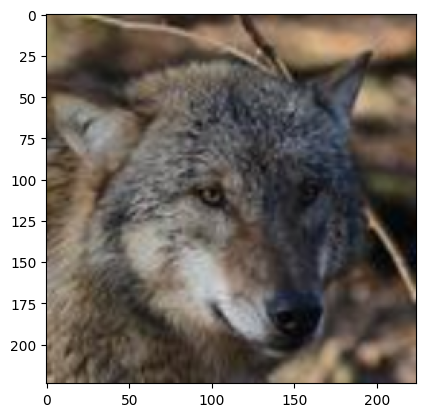

In [ ]:
conv_img = cv2.cvtColor(np.array(x_train[1]).astype(np.uint8), cv2.COLOR_BGR2RGB)
plt.imshow(conv_img)
print(y_train[1])

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import ResNet50

inputs = layers.Input(shape=(224, 224, 3))
outputs = ResNet50(include_top=True, weights=None, classes=3)(inputs)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"] )

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 3)                 23593859  
                                                                 
Total params: 23593859 (90.00 MB)
Trainable params: 23540739 (89.80 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [ ]:
hist = model.fit(x_train, y_train, epochs=20, batch_size=32, verbose=1)

Epoch 1/20
19/19 [==============================] - 443s 22s/step - loss: 1.8740 - accuracy: 0.3933
Epoch 2/20
19/19 [==============================] - 416s 22s/step - loss: 0.9860 - accuracy: 0.5900
Epoch 3/20
19/19 [==============================] - 414s 22s/step - loss: 0.7593 - accuracy: 0.6550
Epoch 4/20
19/19 [==============================] - 410s 22s/step - loss: 0.6691 - accuracy: 0.7067
Epoch 5/20
19/19 [==============================] - 419s 22s/step - loss: 0.6433 - accuracy: 0.7433
Epoch 6/20
19/19 [==============================] - 415s 22s/step - loss: 0.5611 - accuracy: 0.7900
Epoch 7/20
19/19 [==============================] - 412s 22s/step - loss: 0.6512 - accuracy: 0.7083
Epoch 8/20
19/19 [==============================] - 408s 22s/step - loss: 0.4426 - accuracy: 0.8283
Epoch 9/20
19/19 [==============================] - 413s 22s/step - loss: 0.6227 - accuracy: 0.7583
Epoch 10/20
19/19 [==============================] - 407s 21s/step - loss: 0.5148 - accuracy: 0.7967

In [ ]:
test_score = model.evaluate(x_test, y_test)
print("Test loss {:.4f}, accuracy {:.2f}%".format(test_score[0], test_score[1] * 100))

4/4 [==============================] - 21s 4s/step - loss: 3.5090 - accuracy: 0.5905
Test loss 3.5090, accuracy 59.05%


In [5]:
hist.history

{'loss': [1.874016523361206,
  0.9860323071479797,
  0.7592946887016296,
  0.6691009998321533,
  0.6433039307594299,
  0.5610644817352295,
  0.6512346267700195,
  0.44263169169425964,
  0.6226553320884705,
  0.5147818922996521,
  0.4351877272129059,
  0.3113715946674347,
  0.29152587056159973,
  0.33312511444091797,
  0.21696485579013824,
  0.20124168694019318,
  0.2600648105144501,
  0.14542198181152344,
  0.08655042946338654,
  0.1544143706560135],
 'accuracy': [0.3933333456516266,
  0.5899999737739563,
  0.6549999713897705,
  0.7066666483879089,
  0.7433333396911621,
  0.7900000214576721,
  0.7083333134651184,
  0.82833331823349,
  0.7583333253860474,
  0.79666668176651,
  0.8483333587646484,
  0.8766666650772095,
  0.8999999761581421,
  0.8833333253860474,
  0.9200000166893005,
  0.9300000071525574,
  0.9066666960716248,
  0.9516666531562805,
  0.9700000286102295,
  0.9433333277702332]}

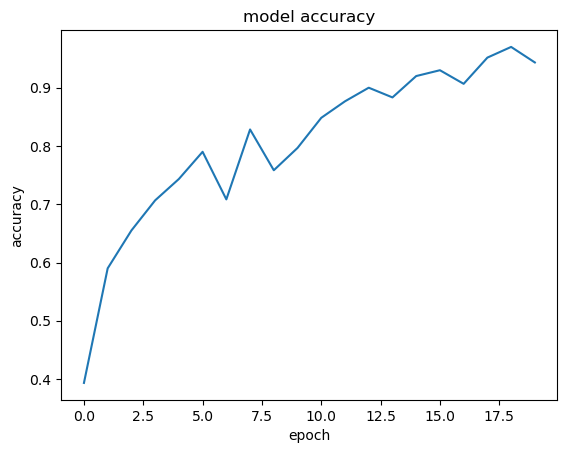

In [6]:
# summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

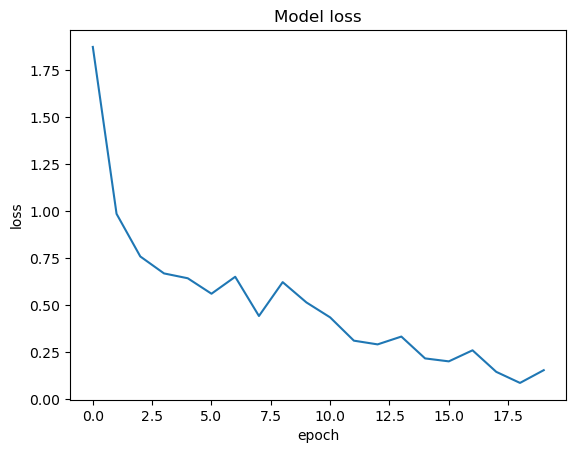

In [5]:
# summarize history for accuracy
plt.plot(hist.history['loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.save("resnet_animal.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [10]:
from tensorflow.keras.models import load_model
filepath = "/content/sample_data/resnet_animal.h5"
savedModel=load_model(filepath)
savedModel.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 3)                 23593859  
                                                                 
Total params: 23593859 (90.00 MB)
Trainable params: 23540739 (89.80 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


4/4 [==============================] - 5s 846ms/step
[1 1 1 1 2 2 0 2 2 2 1 2 2 2 2 2 0 2 0 0 0 2 0 1 1 1 0 2 1 2 0 0 2 1 2 2 1
 1 1 1 1 1 1 1 2 2 1 1 1 1 2 2 2 2 2 2 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 1 2 2 1 2 2 2 1 0 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


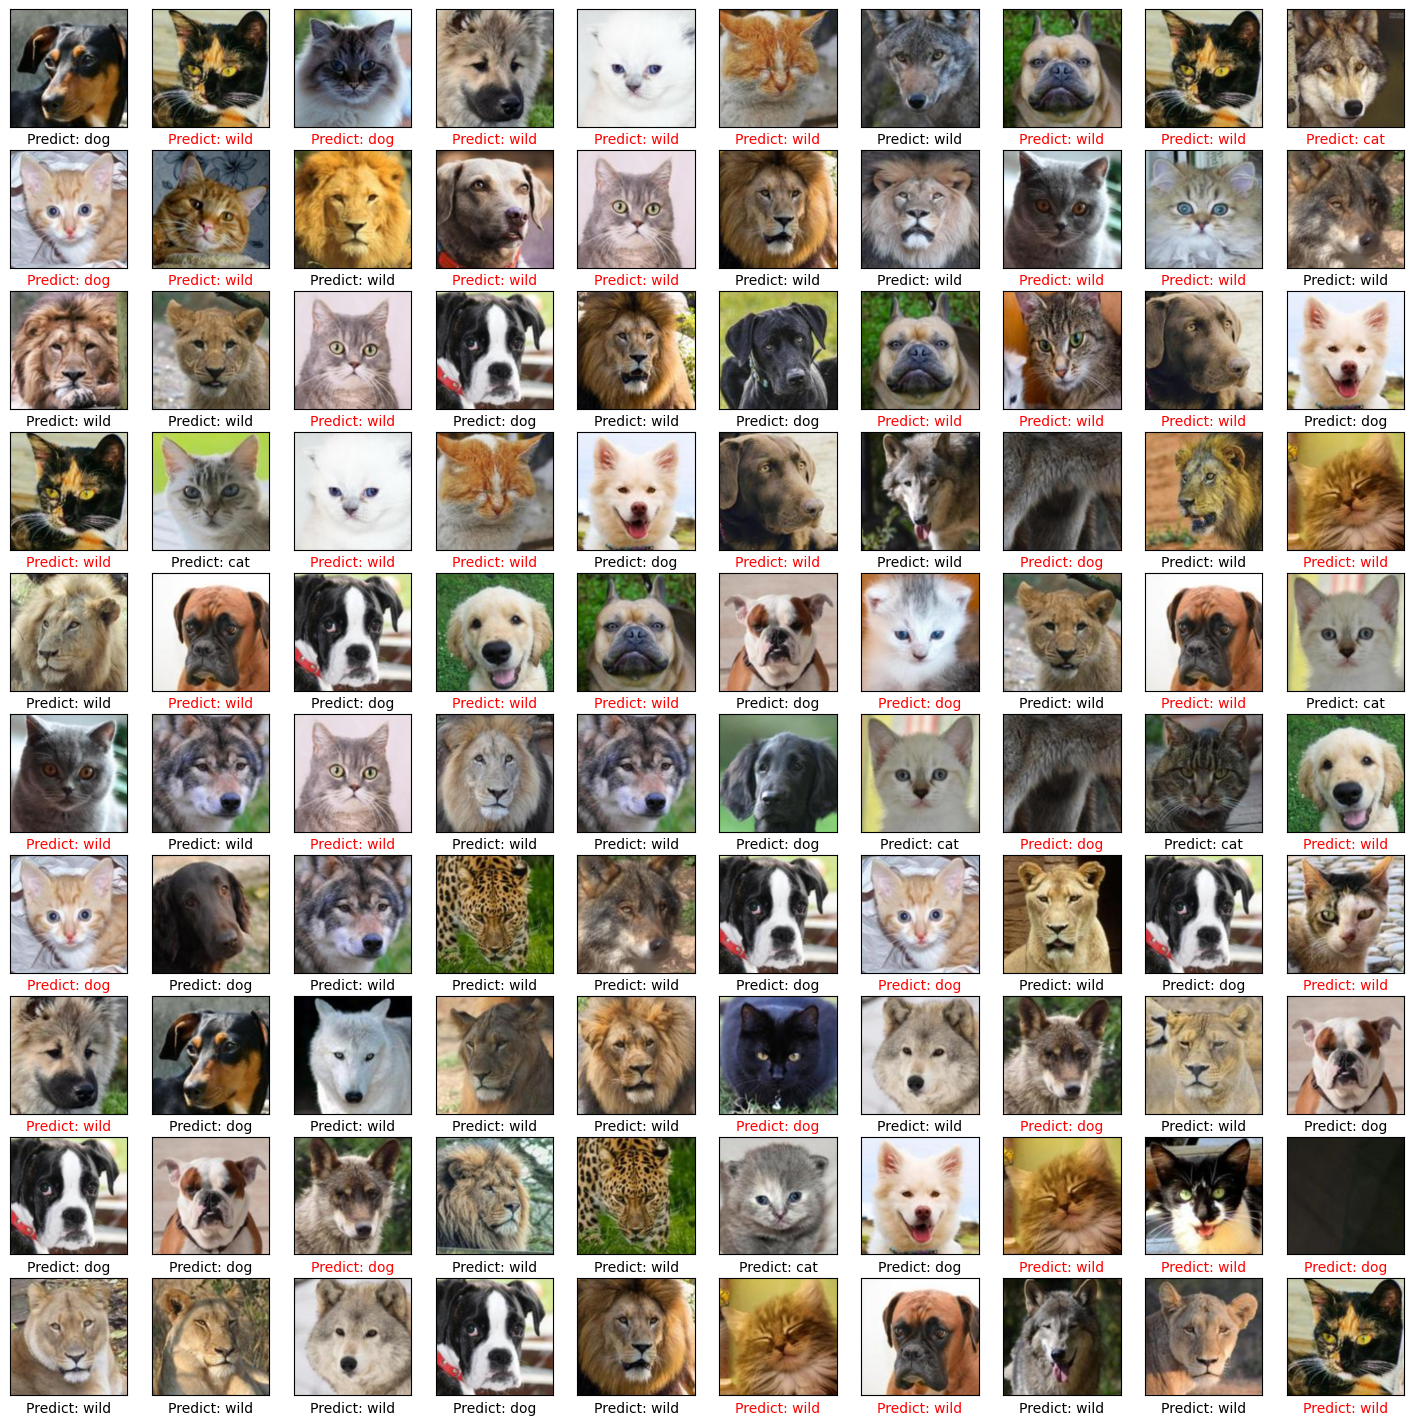

In [11]:
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import classification_report

# A helper function that returns 'red'/'black' depending on if its two input
# parameter matches or not.
def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

# Predict the labels of digit images in our test dataset.
predictions = savedModel.predict(x_test[:200])

# As the model output 10 float representing the probability of the input image
# being a digit from 0 to 9, we need to find the largest probability value
# to find out which digit the model predicts to be most likely in the image.
predictions = np.argmax(predictions, axis=1)
y = np.argmax(y_test, axis=1)
print(predictions)
_class = {0: 'cat',
          1: 'dog',
          2: 'wild'}
# clasifies = []
# for i in range(len(predictions)):
#   clasifies.append(_class[predictions[i]])
# Then plot 100 random test images and their predicted labels.
# If a prediction result is different from the label provided label in "test"
# dataset, we will highlight it in red color.

plt.figure(figsize=(18, 18))

for i in range(100):
    ax = plt.subplot(10, 10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_index = random.randint(0, len(predictions))
    img_path = x_test[image_index]
#     print(img_path)
#     print(len(img_path.shape)) // return 3
    if(len(img_path.shape) == 3):
        conv_img = cv2.cvtColor(np.array(img_path).astype(np.uint8), cv2.COLOR_BGR2RGB)
        plt.imshow(np.squeeze(conv_img), cmap=plt.cm.gray)
    elif(len(img_path.shape) == 2):
        conv_img = cv2.cvtColor(np.array(x_train[1]).astype(np.uint8), cv2.COLOR_BGR2RGB)
        plt.imshow(conv_img)
    else:
        print("Higher dimensional data")
    ax.xaxis.label.set_color(get_label_color(predictions[image_index],\
                                           int(y[image_index])))
    plt.xlabel('Predict: '+ _class[predictions[image_index]])
plt.show()